In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from decimal import Decimal
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
dr = '~/Projects/video-qoe-labeling/'
dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Quality': np.int32}
df = pd.read_table(dr + 'data.txt', delim_whitespace=True, dtype = dtype)
df['BitRate'] /= 100  # transforming BitRate to percentages

In [3]:
classifiers = {'Random Forest': RandomForestClassifier(random_state = 1), 
               'Nearest Neighbors': KNeighborsClassifier(),
               'Naive Bayers': GaussianNB(),
               'SVM': SVC(probability = True),
               'MLP': MLPClassifier(random_state = 1, max_iter = 10000),
               'AdaBoost': AdaBoostClassifier(random_state = 1)
              }

params = {'Random Forest': {'n_estimators': range(1, 21), 'criterion': ('gini', 'entropy')},
          'Nearest Neighbors': {'n_neighbors':range(1, 11)},
          'Naive Bayers': {},
          'SVM': {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]},
          'MLP': {'hidden_layer_sizes': [(5,), (10,), (25,), (50,), (100,), (200,)], 
                  'alpha': [0.0001, 0.001],
                  'activation': ('logistic', 'tanh', 'relu'), 
                  'solver': ('lbfgs', 'sgd', 'adam')},
          'AdaBoost': {'n_estimators': [10, 25, 50, 100], 'learning_rate': [0.01, 0.1, 1, 10]}
         }

In [4]:
# get (X, y) and set fold
X, y = np.array(df[['BitRate', 'FreezeRatio']]), np.array(df['Quality'])
accuracies = {}
confusion = {}
fold = 5

In [5]:
# function for obtaining best estimator using grid search
def grid_search(estimator, params):
    clf = GridSearchCV(estimator, params)
    clf.fit(X, y)
    return (clf.best_estimator_, clf.best_score_)

# function for performing k-fold cross validation 
def k_Fold_CV(estimator, n):
    accuracies = []
    confusion = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        pred = estimator.fit(X[train], y[train]).predict(X[test])
        accuracies.append(estimator.score(X[test], y[test]))
        confusion.append(confusion_matrix(y[test], pred))
    return (accuracies, confusion)

In [6]:
best_classifiers = {}
for k in classifiers.keys():
    best_classifiers[k], _ = grid_search(classifiers[k], params[k])
    accuracies[k], confusion[k] = k_Fold_CV(best_classifiers[k], fold)

In [7]:
for k, v in accuracies.items():
    print(k)
    print("{}_fold accuracies: ".format(fold), np.around(v, decimals = 3))
    print("Average accuracy: {0:0.3f}".format(np.mean(v)))
    print("range: {}-{}".format(np.min(v), np.maximum(v)))
    print("Standard deviation: {0:0.3f}".format(np.std(v)))
    print("#################################")

Random Forest
10_fold accuracies:  [0.833 0.8   0.933 1.    0.8   0.7   0.867 0.867 0.933 0.933]
Average accuracy: 0.867
Standard deviation: 0.083
#################################
Nearest Neighbors
10_fold accuracies:  [0.867 0.8   0.867 1.    0.8   0.7   0.9   0.867 0.933 0.933]
Average accuracy: 0.867
Standard deviation: 0.080
#################################
Naive Bayers
10_fold accuracies:  [0.9   0.767 0.9   1.    0.867 0.8   0.9   0.867 0.933 0.933]
Average accuracy: 0.887
Standard deviation: 0.064
#################################
SVM
10_fold accuracies:  [0.833 0.667 0.867 1.    0.767 0.9   0.833 0.867 0.9   0.933]
Average accuracy: 0.857
Standard deviation: 0.087
#################################
MLP
10_fold accuracies:  [0.8   0.867 0.967 0.933 0.867 0.767 0.9   0.8   0.967 0.9  ]
Average accuracy: 0.877
Standard deviation: 0.067
#################################
AdaBoost
10_fold accuracies:  [0.9   0.767 0.867 0.9   0.8   0.767 0.8   0.767 0.933 0.933]
Average accuracy: 0.

In [33]:
for name, clf in best_classifiers.items():
    print(name, 'accuracy: {}'.format(np.around(clf.score(X,y), decimals = 3)))

Random Forest accuracy: 0.967
Nearest Neighbors accuracy: 0.927
Naive Bayers accuracy: 0.893
SVM accuracy: 0.867
MLP accuracy: 0.99
AdaBoost accuracy: 0.873


In [31]:
# binarize labels
classes = [0,1,2]
y_bin = label_binarize(y, classes = classes)

# function for computing the ROC curves in k-fold CV
def k_Fold_roc(clf, n):
    aucs = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        _, _, a = get_roc(X[train], y_bin[train], X[test], y_bin[test], clf)
        aucs.append(a)
    return aucs 

def plot_roc(fpr, tpr, roc_auc, clf_name, lb):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}, Class {}'.format(clf_name, lb))
    plt.legend(loc="lower right")
    plt.show()
        
def get_roc(X_tr, y_tr, X_te, y_te, clf):
    fpr = {}
    tpr = {}
    roc_auc = {}
    y_score = ovr(clf).fit(X_tr, y_tr).predict_proba(X_te)
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return (fpr, tpr, roc_auc)

In [9]:
# get k-fold CV roc data for each classifier
aucs = {}
for k, v in best_classifiers.items():
    aucs[k] = k_Fold_roc(v, fold)

In [10]:
for k, v in aucs.items():  # v is a list of dictionaries
    print(k)
    print("{}_fold AUCs: ".format(fold))
    for x in v:  # x is a dictionary {'label': AUC}
        print({l:'{0:5.3f}'.format(x[l]) for l in x.keys()})
    print("#################################")

Random Forest
10_fold AUCs: 
{0: '1.000', 1: '0.896', 2: '0.870'}
{0: '1.000', 1: '0.902', 2: '0.912'}
{0: '1.000', 1: '0.980', 2: '0.987'}
{0: '1.000', 1: '1.000', 2: '0.994'}
{0: '0.921', 1: '0.667', 2: '0.973'}
{0: '1.000', 1: '0.779', 2: '0.938'}
{0: '0.948', 1: '0.894', 2: '0.920'}
{0: '0.963', 1: '0.922', 2: '0.981'}
{0: '0.977', 1: '0.909', 2: '1.000'}
{0: '0.964', 1: '0.942', 2: '1.000'}
#################################
Nearest Neighbors
10_fold AUCs: 
{0: '1.000', 1: '0.896', 2: '0.894'}
{0: '1.000', 1: '0.923', 2: '0.930'}
{0: '1.000', 1: '0.948', 2: '0.966'}
{0: '1.000', 1: '1.000', 2: '1.000'}
{0: '1.000', 1: '0.931', 2: '0.968'}
{0: '1.000', 1: '0.808', 2: '0.826'}
{0: '0.997', 1: '0.935', 2: '0.963'}
{0: '0.970', 1: '0.942', 2: '0.986'}
{0: '0.986', 1: '0.969', 2: '0.998'}
{0: '0.966', 1: '0.934', 2: '1.000'}
#################################
Naive Bayers
10_fold AUCs: 
{0: '1.000', 1: '0.946', 2: '0.954'}
{0: '1.000', 1: '0.780', 2: '0.837'}
{0: '1.000', 1: '0.888', 2: 

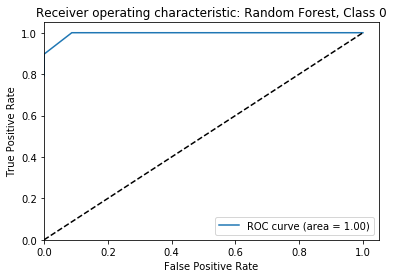

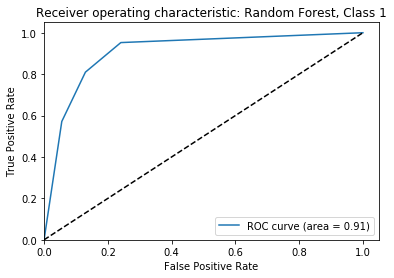

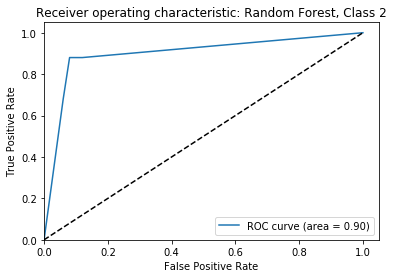

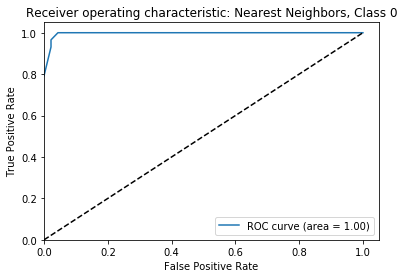

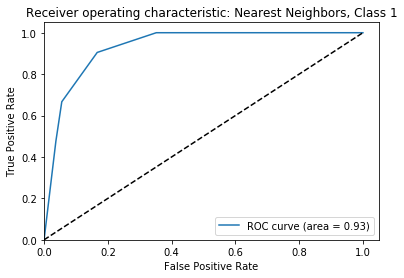

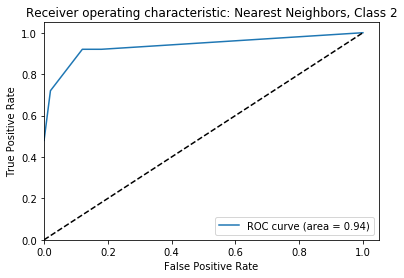

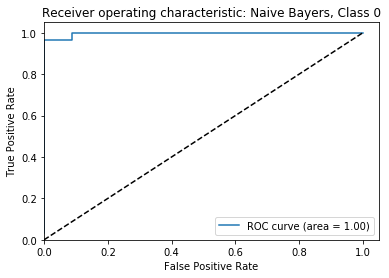

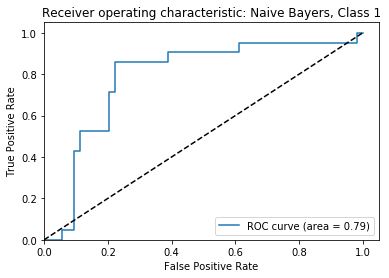

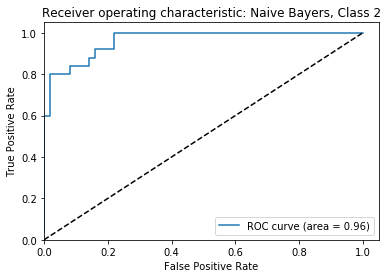

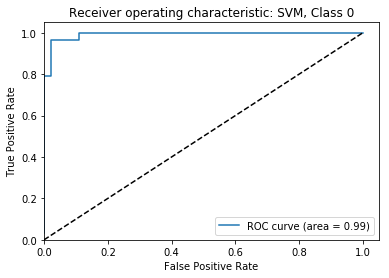

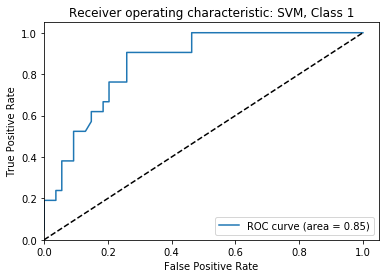

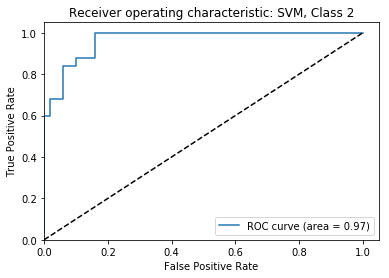

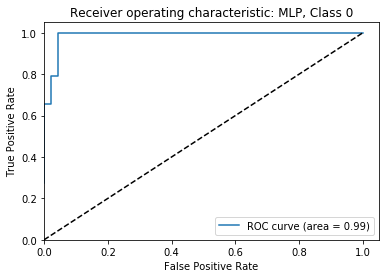

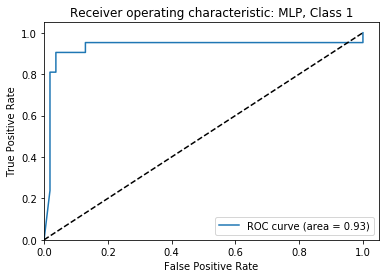

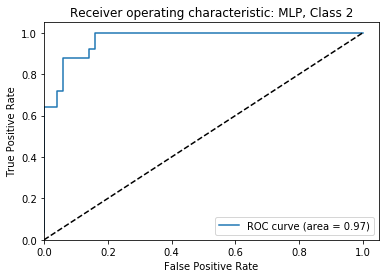

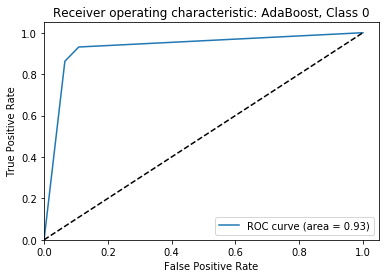

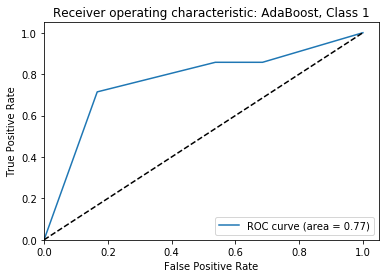

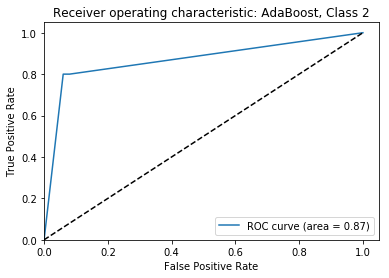

In [11]:
# ROC curves for a random train-test split for each classifier
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.25, random_state = 0)

for k, v in best_classifiers.items():
    fpr, tpr, roc_auc = get_roc(X_train, y_train, X_test, y_test, v)
    for i in classes:
        plot_roc(fpr[i], tpr[i], roc_auc[i], k, i)

In [20]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf_name, xx, yy, **params):
    Z = best_classifiers[clf_name].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

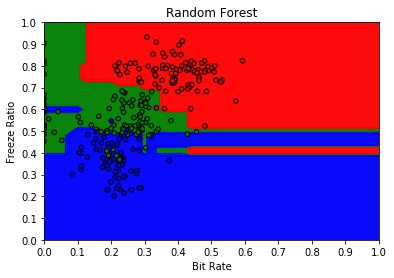

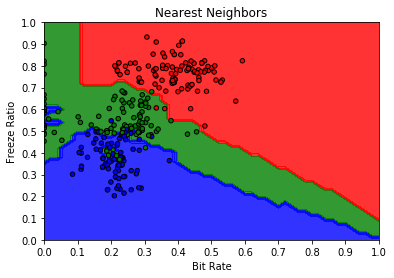

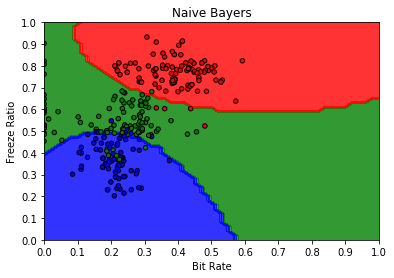

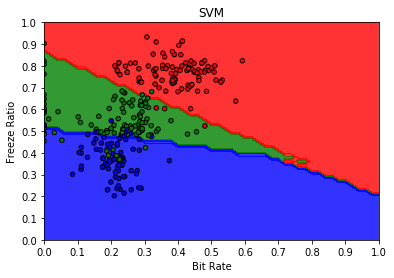

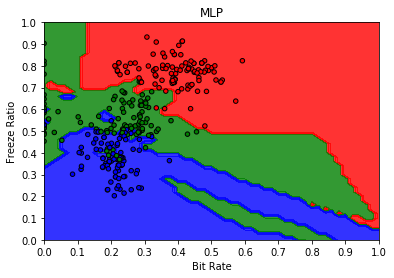

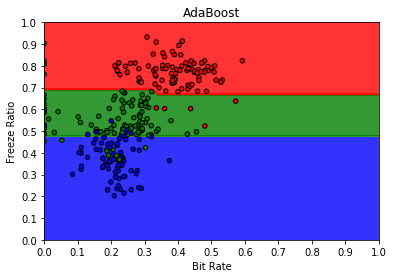

In [22]:
colors = ['red', 'green', 'blue']
cmap = mpl.colors.ListedColormap(colors)
rg = np.arange(0, 1.01, 0.01)
x1, x2, lb = np.array(df['BitRate']), np.array(df['FreezeRatio']), np.array(df['Quality'])
xx1, xx2 = make_meshgrid(rg, rg)
for clf in best_classifiers:
    plot_contours(clf, xx1, xx2, cmap=cmap, alpha=0.8)
    plt.scatter(x1, x2, c = lb, cmap=cmap, s=20, edgecolors='k')
    plt.xlim(rg.min(), rg.max())
    plt.ylim(rg.min(), rg.max())
    plt.xlabel('Bit Rate')
    plt.ylabel('Freeze Ratio')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(clf)
    plt.show()